UNET for Multi-class Segmentation of Brain Tumors (meningioma, glioma, pituitary tumor)

NOTE: Restart the Python kernel between runs to clear the state

Pip Install all Packages via Terminal in the Correct activated VENV
OR !pip install package below if Jupyter

VENV for local installs: source SPR24ENV/bin/activate 
VENV for cluster installs: source UNETvenv/bin/activate 

In [59]:
import os
import sys
import numpy as np
import pandas as pd
import cv2  # opencv+python == 4.9.0.80 # image processing
import matplotlib.pyplot as plt
import hdf5storage  # 0.1.19 # for loading .mat files

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf # Ensure using 2.13.0 as mentioned
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, Activation)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam # trying legacy Adam for better performance
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator # optional data augmentation

import seaborn as sns
from collections import Counter
from skimage.metrics import structural_similarity as ssim

Ensure GPU is Connected for Local & Cluster Runs

In [60]:
# local check
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available; TensorFlow is using CPU")

# cluster check

GPU is available


Data Loading

In [61]:
path = '/Users/elizabethnemeti/Desktop/' # local runs
data_dir = os.path.join(path, 'data') # local runs
# data_dir = '/' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}") # debug check

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see 2124 mat files from Cheng 2016 dataset

Files in /Users/elizabethnemeti/Desktop/data: ['Case_58_Day_2_brightest.png', 'Case_17_Day_1_brightest.png', 'Case_16_Day_5_brightest.png', 'Case_73_Day_3_brightest.png', 'Case_41_Day_2_brightest.png', 'Case_59_Day_2_brightest.png', 'Case_40_Day_2_brightest.png', 'Case_72_Day_3_brightest.png', 'Case_16_Day_1_brightest.png', 'Case_71_Day_3_brightest.png', 'Case_12_Day_2_brightest.png', 'Case_44_Day_1_brightest.png', 'Case_14_Day_5_brightest.png', 'Case_15_Day_1_brightest.png', 'Case_45_Day_5_brightest.png', 'Case_9_Day_1_brightest.png', 'Case_68_Day_3_brightest.png', 'Case_45_Day_1_brightest.png', 'Case_44_Day_5_brightest.png', 'Case_14_Day_1_brightest.png', 'Case_83_Day_3_brightest.png', 'Case_13_Day_2_brightest.png', 'Case_21_Day_3_brightest.png', 'Case_70_Day_3_brightest.png', 'Case_38_Day_3_brightest.png', 'Case_69_Day_3_brightest.png', 'Case_27_Day_3_brightest.png', 'Case_15_Day_2_brightest.png', 'Case_44_Day_2_brightest.png', 'Case_12_Day_1_brightest.png', 'Case_12_Day_5_brightest

Low Quality MRI Manually Inspected and Removed
- available in folder Poor_Quality_Discarded_Images

Data Preprocessing Pipeline

Sample = Pixel
- every pixel is treated separately and hails from the original images

Input: 512 x 512 images

- each mask will be labeled according to the tumor type (each class is represented by different integer labels in the mask)
- labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively
- include one-hot encoding for masks to ensure each mask is transformed into a binary format suitable for multi-class segmentation using categorical crossentropy in training/model architecture

1. Normalize pixel values
2. Create label classes for the 3 tumors
3. Make sure data types match as float32 for images and masks

ACTION REQUIRED: Select Resolution 128, 256, 512 pixels

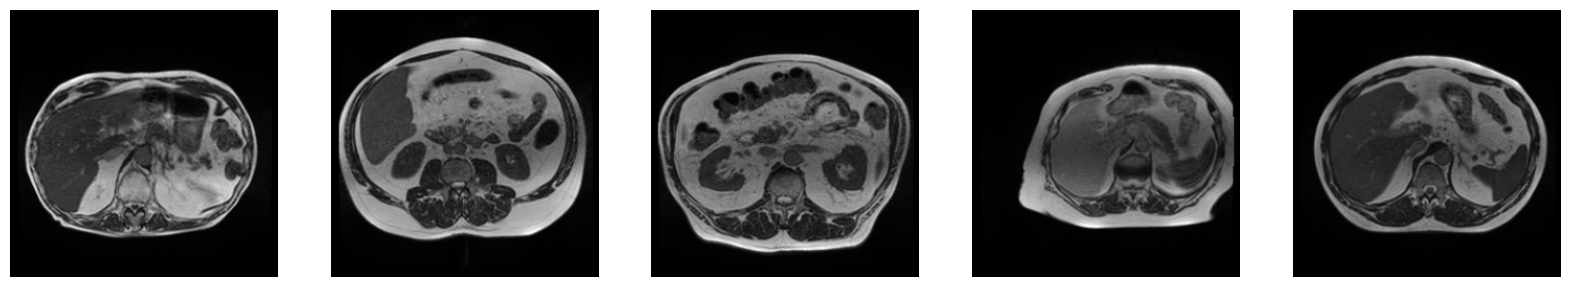

Data type of image: float32
Data type of masks: float64


In [62]:
# Path to your stomach PNG data
data_dir = '/Users/elizabethnemeti/Desktop/data'

def load_stomach_images(data_dir, image_dimension=256):
    images = []
    files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
    
    for file in files:
        img = cv2.imread(os.path.join(data_dir, file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_dimension, image_dimension))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append(img)

    return np.array(images)

images = load_stomach_images(data_dir, image_dimension=256)

def visualize_images(images, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_images(images)

# debug check
print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

Save .mat as .png (optional)

def convert_mat_to_png(data_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and f != '.DS_Store']
    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]
            
            image = mat_file['image']
            
            image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
            image = image.astype(np.uint8)
            
            image_filename = os.path.join(output_dir, f"{os.path.splitext(file)[0]}.png")
            cv2.imwrite(image_filename, image)
            
            print(f"Saved {image_filename}")
        except Exception as e:
            print(f"Failed to process file {file}: {e}")

data_dir = '/Users/elizabethnemeti/Desktop/data'
output_dir = '/Users/elizabethnemeti/Desktop/pngs'
image_dimension = 256  # Change if needed

convert_mat_to_png(data_dir, output_dir)

Check Dimensions Before Training (optional, recommended)

- MRI scans are generally single-channel (grayscale), where each pixel represents an intensity value.
- Lack of an explicit channel dimension in the arrays ((512, 512) instead of (512, 512, 1)) is common because the single channel is implicit in grayscale images.
- However, for processing in DL models like U-Net, we need to explicitly include the channel dimension.

- FOR IMAGES: typically single-channel for grayscale -> correct shape is (512, 512, 1) for DL processing
- FOR MASKS: for multi-class segmentation, especially when one-hot encoded with three classes (Meningioma, Glioma, Pituitary Tumor), should have shape (512, 512, 3) where each channel corresponds to one class

In [63]:
def check_dimensions(images, required_image_shape):
    assert images[0].shape == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images[0].shape}"
    print(f"Image shape is {images[0].shape}.")
    print("All images correctly match the required shape.")

# Required shape for U-Net
required_image_shape = (256, 256, 1)  # for the images -> grayscale and should have a single channel explicitly

check_dimensions(images, required_image_shape)

Image shape is (256, 256, 1).
All images correctly match the required shape.


Splitting the dataset into Training, Validation and Test Set

- Split Training, Validation and Testing data
- 80% (60:20) training + validation -> data for learning and to tune the model's hyperparameters without overfitting
- 20% testing -> to evaluate model's performance on unseen data
- Using Single validation split strategy for less computation time/resources
- use 5-fold cross validation if computational resources allow

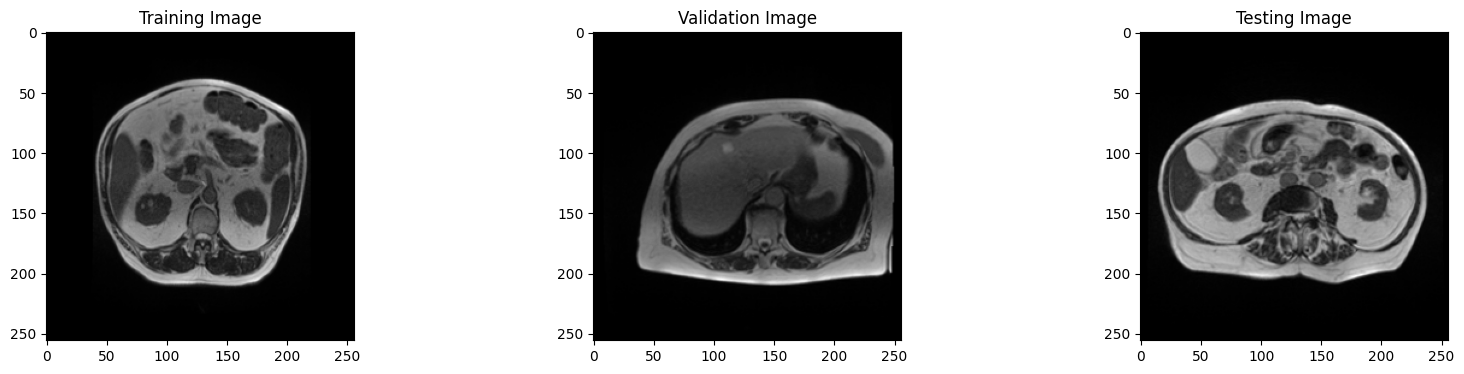

Data type of images_train: float32
Data type of images_val: float32
Data type of images_test: float32
Training Images shape: (113, 256, 256, 1)
Validation Images shape: (38, 256, 256, 1)
Testing Images shape: (38, 256, 256, 1)


In [64]:
def split_data(images, test_size=0.2, val_size=0.25, random_state=42):
    """
    Split data into training, validation, and testing sets.
    - test_size specifies the proportion of the data for testing.
    - val_size specifies the proportion of the training data for validation.
    """
    
    # Split the dataset into training and testing sets
    images_train, images_test = train_test_split(images, test_size=test_size, random_state=random_state)
    
    # Further split the training set into training and validation sets
    images_train, images_val = train_test_split(images_train, test_size=val_size, random_state=random_state)
    
    return np.array(images_train), np.array(images_val), np.array(images_test)

def visualize_data_samples(images_train, images_val, images_test):
    """Display the first image from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    axes[0].imshow(images_train[0].squeeze(), cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(images_val[0].squeeze(), cmap='gray')
    axes[1].set_title('Validation Image')
    axes[2].imshow(images_test[0].squeeze(), cmap='gray')
    axes[2].set_title('Testing Image')
    plt.show()

# Call function to split the filtered data into training, validation, and testing sets
images_train, images_val, images_test = split_data(images, test_size=0.2, val_size=0.25)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, images_val, images_test)

# DEBUG: Check data types to make sure images are float32
print(f"Data type of images_train: {images_train.dtype}")
print(f"Data type of images_val: {images_val.dtype}")
print(f"Data type of images_test: {images_test.dtype}")

print(f"Training Images shape: {images_train.shape}")
print(f"Validation Images shape: {images_val.shape}")
print(f"Testing Images shape: {images_test.shape}")

data_sets = {
    'training': images_train,
    'validation': images_val,
    'testing': images_test
}


In [65]:
def mean_squared_error(true_image, pred_image):
    return tf.reduce_mean(tf.square(true_image - pred_image))

def mean_ssim(true_image, pred_image):
    ssim_values = tf.image.ssim(true_image, pred_image, max_val=1.0)
    return tf.reduce_mean(ssim_values)

In [66]:
class MetricsCollector(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCollector, self).__init__()
        self.validation_data = validation_data
        self.metrics_history = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_images = self.validation_data
        pred_images = self.model.predict(val_images)

        # Calculate MSE
        mse_value = mean_squared_error(val_images, pred_images).numpy()
        logs['val_mean_squared_error'] = mse_value

        # Calculate SSIM
        ssim_value = mean_ssim(val_images, pred_images)
        logs['val_mean_ssim'] = ssim_value

        self.metrics_history.append(logs)
        print(f"Epoch {epoch + 1} validation metrics collected - MSE: {mse_value:.4f}, SSIM: {ssim_value:.4f}")

    def on_train_end(self, logs=None):
        """
        Converts the historical metrics into a Pandas DataFrame and prints it for easy visualization.

        Args:
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        import pandas as pd
        metrics_df = pd.DataFrame(self.metrics_history)
        print("Training Metrics per Epoch:")
        print(metrics_df.to_string(index=False))
        self.metrics_df = metrics_df

In [67]:
# set training parameters early 
num_samples = len(images_train)
#learning_rate = 1e-4 # e.g. 1e-5 for mini updates/slower convergence -> 1e-1 for big weight updates/faster convergence
initial_learning_rate = 1e-4
# epochs set here for both models
epochs = 20
batch_size = 8
steps_per_epoch = num_samples // batch_size
seed = 30

In [68]:
def unet(weights=None, input_size=(256, 256, 1)):
    """
    Creates a U-Net model for image reconstruction.

    Args:
         weights: Path to pre-trained weights file (optional).
        input_size: Size of the input image (width, height, channels). Defaults to (256, 256, 1) for grayscale images.

    Returns:
        A compiled U-Net model for image reconstruction.
    """

    inp = Input(input_size)

    # --------------------------
    # Encoder (Contracting Path)
    # --------------------------

    # Block 1: Two convolutional layers followed by pooling to downsample
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    # Block 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    # Block 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Block 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Block 5: Bottleneck part, no pooling
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # --------------------------
    # Decoder (Expanding Path)
    # --------------------------

    # Block 6: Upsample and concatenate with corresponding encoder layer
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    concat6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    # Block 7
    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    concat7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Block 8: Upsample and concatenate with corresponding encoder layer
    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    concat8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)  # Apply dropout for regularization

    # Block 9: Final upsampling and concatenation with the first encoder layer
    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    concat9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output Layer: Change to single channel output with sigmoid activation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model assembly
    model = Model(inputs=[inp], outputs=[outputs])

    # Compile model with chosen optimizer, loss function, and metrics
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mean_squared_error', 
        metrics=[mean_squared_error, mean_ssim]
    )

    return model

Original batch shape: (8, 256, 256, 1)
Augmented batch shape: (8, 256, 256, 1)


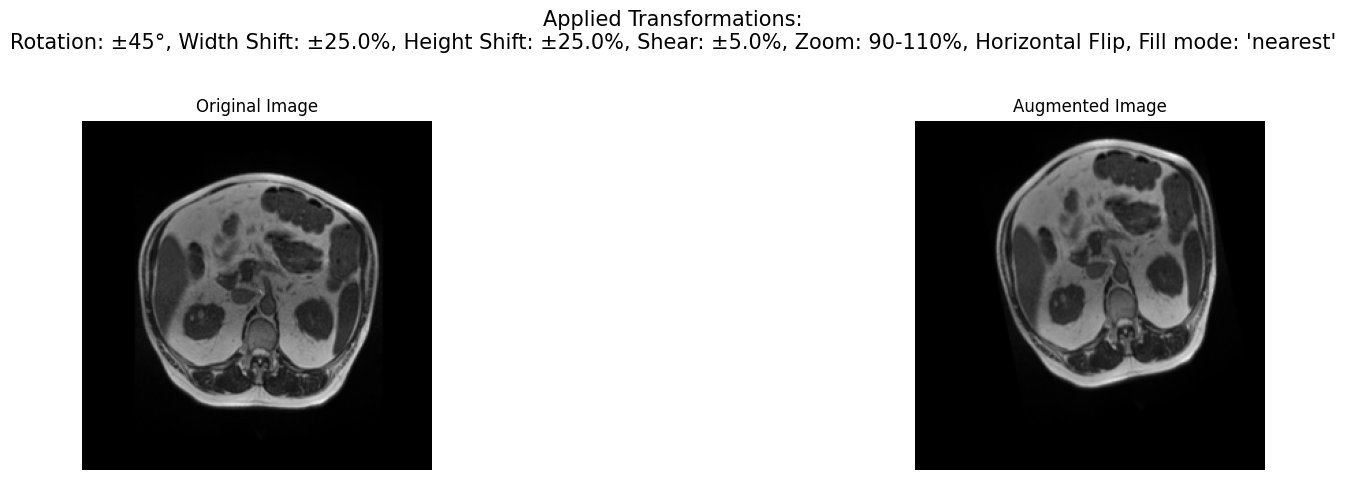

Checking first batch output:
Augmented image batch shape is correct: (8, 256, 256, 1)


In [69]:
# Data Augmentation (optional, recommended)
is_augmented = True  # activate augmentation Y/N?

# Function to indicate whether or not augmentation (and its params) should be applied via boolean 'augment'
def get_augmentation_params(is_augmented):
    if is_augmented:  # will augment
        return {
            'rotation_range': 45,  # rotate left-right by x degrees (0-360 degrees max, 0-90 typical)
            'width_shift_range': 0.25,  # shift horizontally (10% shift up of total img width) -> simulates subject off center
            'height_shift_range': 0.25,  # shift vertically (10% shift up of total img height) -> simulates subject off center
            'shear_range': 0.05,  # change angle of looking at target (0-25 degrees)
            'zoom_range': [0.9, 1.1],  # add zoom to image -> simulates viewing target from closer/farther away; 0.9 = 90% original image shown so very zoomed out to 110% of image shown so zoomed in
            'horizontal_flip': True,  # yes/no flipped horizontally -> effective for images not greatly affected by flipped orientation e.g. landscape vs number
            'fill_mode': 'nearest'  # directs how to fill new pixels following a rotations/shift transformation
        }
    else:
        return {'fill_mode': 'nearest'}  # won't augment

# Create one generator for images
def create_augmentation_generator(images, batch_size, seed, apply_augmentation=True):
    images = np.array(images)

    if apply_augmentation:
        augmentation_params = get_augmentation_params(True)
    else:
        augmentation_params = {'fill_mode': 'nearest'}  # Minimal transformation

    augmentor = ImageDataGenerator(**augmentation_params)

    generator = augmentor.flow(
        images,
        batch_size=batch_size,
        seed=seed,
        shuffle=False  # keep shuffling off to maintain original img for comparison with augmented img
    )

    while True:
        images_batch = next(generator)
        yield images_batch

original_generator = create_augmentation_generator(images_train, batch_size, seed, apply_augmentation=False)
augmented_generator = create_augmentation_generator(images_train, batch_size, seed, apply_augmentation=True)

# For development ONLY -> use visualizations to verify augmentation went smoothly/images are acceptable
def compare_original_and_augmented(original_gen, augmented_gen, num_samples=1):
    augmentation_params = get_augmentation_params(True)  # True because we need the full set for description
    fig, axes = plt.subplots(num_samples, 2, figsize=(20, 5 * num_samples))

    # Description that's auto updated according to the parameters for on-sight interpretability
    # Begin desc creation
    transformations = [
        f"Rotation: ±{augmentation_params['rotation_range']}°",
        f"Width Shift: ±{augmentation_params['width_shift_range']*100}%",
        f"Height Shift: ±{augmentation_params['height_shift_range']*100}%",
        f"Shear: ±{augmentation_params['shear_range']*100}%",
        f"Zoom: {int(augmentation_params['zoom_range'][0]*100)}-{int(augmentation_params['zoom_range'][1]*100)}%",
        "Horizontal Flip" if augmentation_params['horizontal_flip'] else "No Horizontal Flip",
        f"Fill mode: '{augmentation_params['fill_mode']}'"
    ]
    transformation_description = "Applied Transformations:\n" + ", ".join(transformations)
    fig.suptitle(transformation_description, fontsize=15)  # added as header
    # End desc creation

    for i in range(num_samples):
        orig_images_batch = next(original_gen)
        aug_images_batch = next(augmented_gen)

        print(f"Original batch shape: {orig_images_batch.shape}")  # Debug print to check the shape
        print(f"Augmented batch shape: {aug_images_batch.shape}")  # Debug print to check the shape

        axes_flat = axes.flatten()  # Flatten axes array to handle indexing properly
        axes_flat[2*i].imshow(orig_images_batch[0].squeeze(), cmap='gray')  # img 1 - original img
        axes_flat[2*i].set_title('Original Image')
        axes_flat[2*i].axis('off')

        axes_flat[2*i + 1].imshow(aug_images_batch[0].squeeze(), cmap='gray')  # img 2 - augmented img
        axes_flat[2*i + 1].set_title('Augmented Image')
        axes_flat[2*i + 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # make space for header
    plt.show()

compare_original_and_augmented(original_generator, augmented_generator, num_samples=1)  # call the plots -> do the images look acceptable?

# DEBUG CHECK: do our post data-augmentation model inputs match the required dimension and shape for training?
def check_augmented_data_shape(images_train, batch_size, is_augmented):
    if is_augmented:
        print("Checking first batch output:")
        generator = create_augmentation_generator(images_train, batch_size, seed, apply_augmentation=True)
        sample_img_output = next(generator)

        assert sample_img_output.shape == (batch_size, images_train.shape[1], images_train.shape[2], images_train.shape[3]), \
            f"Augmented image shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_img_output.shape}"
        print(f"Augmented image batch shape is correct: {sample_img_output.shape}")
    else:
        print(f"Images shape: {images_train.shape}")
        print("Non-augmented data shapes are correct.")

images_train = np.array(images_train)  # need to be in array format to work

check_augmented_data_shape(images_train, batch_size, is_augmented)

In [70]:
class VisualizeSegmentation(Callback):
    """
    Custom callback to visualize predicted images during training epochs.

    This callback is intended for debugging and monitoring purposes. Generally not recommended for
    regular training as it can slow down the process.

    Args:
        model: The Keras model being trained.
        validation_data: A tuple of (images) representing the validation data.
        num_samples: Number of validation samples to visualize per epoch (default 1).
    """

    def __init__(self, model, validation_data, num_samples=1):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_samples = num_samples

    def on_epoch_end(self, epoch, logs=None):
        """
        Visualizes predicted images at the end of each training epoch.

        Args:
            epoch: The current epoch number.
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        # Select random validation samples
        idxs = np.random.choice(len(self.validation_data[0]), self.num_samples, replace=False)
        images = self.validation_data[0][idxs]
        preds = self.model.predict(images)

        # Create a Matplotlib figure for visualization
        fig, axes = plt.subplots(self.num_samples, 2, figsize=(6, 3 * self.num_samples))

        for i, (image, pred) in enumerate(zip(images, preds)):
            # Access axes for individual sample plots
            if self.num_samples == 1:
                ax1, ax2 = axes
            else:
                ax1, ax2 = axes[i]

            # Plot original image
            ax1.imshow(image[:, :, 0], cmap='gray')
            ax1.set_title('Original Image')
            ax1.axis('off')

            # Plot predicted mask
            ax2.imshow(pred[:, :, 0], cmap='gray')
            ax2.set_title('Predicted Image')
            ax2.axis('off')

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.show()

In [71]:
images_val = np.array(images_val)
images_test = np.array(images_test)

print(f"Training Images shape: {images_train.shape}")
print(f"Validation Images shape: {images_val.shape}")
print(f"Testing Images shape: {images_test.shape}")

Training Images shape: (113, 256, 256, 1)
Validation Images shape: (38, 256, 256, 1)
Testing Images shape: (38, 256, 256, 1)


Epoch 1/10


2024-06-26 11:16:17.360819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.1308 - mean_squared_error: 0.1287 - mean_ssim: 0.1211

2024-06-26 11:16:28.242774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.14801, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 222ms/step


2024-06-26 11:16:31.049851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


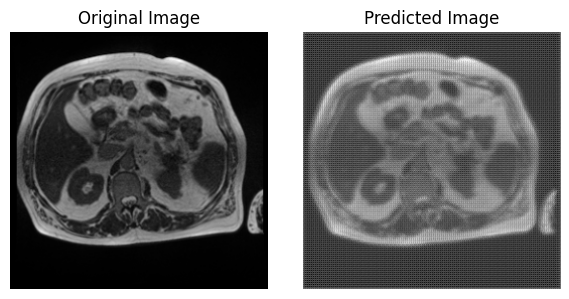

15/15 [==============================] - 15s 881ms/step - loss: 0.1308 - mean_squared_error: 0.1287 - mean_ssim: 0.1211 - val_loss: 0.1480 - val_mean_squared_error: 0.1479 - val_mean_ssim: 0.1759 - lr: 1.0000e-04
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.0638 - mean_squared_error: 0.0641 - mean_ssim: 0.2313
Epoch 2: val_loss improved from 0.14801 to 0.12967, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 38ms/step


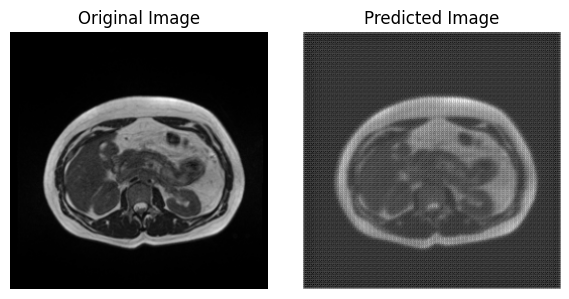

15/15 [==============================] - 12s 770ms/step - loss: 0.0638 - mean_squared_error: 0.0641 - mean_ssim: 0.2313 - val_loss: 0.1297 - val_mean_squared_error: 0.1296 - val_mean_ssim: 0.1863 - lr: 1.0000e-04
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.0448 - mean_squared_error: 0.0444 - mean_ssim: 0.2422
Epoch 3: val_loss improved from 0.12967 to 0.10556, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 16ms/step


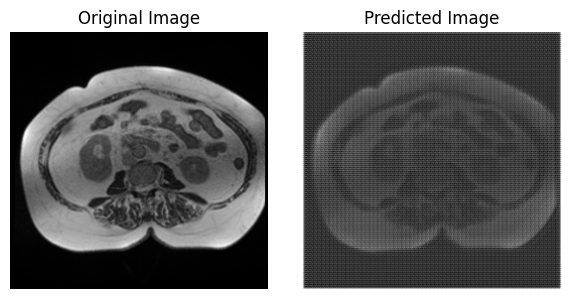

15/15 [==============================] - 10s 702ms/step - loss: 0.0448 - mean_squared_error: 0.0444 - mean_ssim: 0.2422 - val_loss: 0.1056 - val_mean_squared_error: 0.1055 - val_mean_ssim: 0.1784 - lr: 1.0000e-04
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0360 - mean_ssim: 0.2631
Epoch 4: val_loss improved from 0.10556 to 0.08740, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 26ms/step


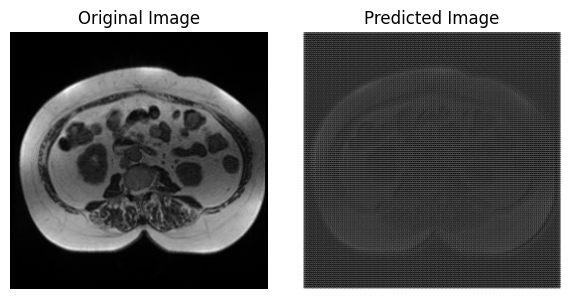

15/15 [==============================] - 11s 747ms/step - loss: 0.0352 - mean_squared_error: 0.0360 - mean_ssim: 0.2631 - val_loss: 0.0874 - val_mean_squared_error: 0.0873 - val_mean_ssim: 0.1624 - lr: 1.0000e-04
Epoch 5/10
15/15 [==============================] - ETA: 0s - loss: 0.0294 - mean_squared_error: 0.0292 - mean_ssim: 0.3079
Epoch 5: val_loss improved from 0.08740 to 0.07480, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 17ms/step


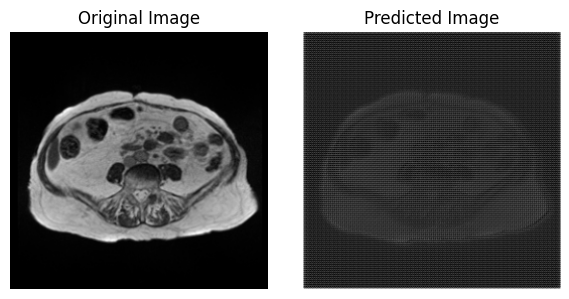

15/15 [==============================] - 11s 710ms/step - loss: 0.0294 - mean_squared_error: 0.0292 - mean_ssim: 0.3079 - val_loss: 0.0748 - val_mean_squared_error: 0.0747 - val_mean_ssim: 0.1588 - lr: 1.0000e-04
Epoch 6/10
15/15 [==============================] - ETA: 0s - loss: 0.0265 - mean_squared_error: 0.0262 - mean_ssim: 0.3314
Epoch 6: val_loss improved from 0.07480 to 0.06558, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 17ms/step


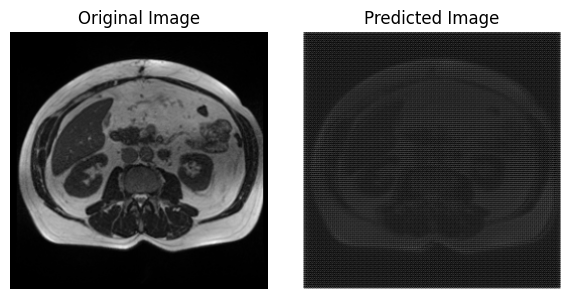

15/15 [==============================] - 11s 737ms/step - loss: 0.0265 - mean_squared_error: 0.0262 - mean_ssim: 0.3314 - val_loss: 0.0656 - val_mean_squared_error: 0.0655 - val_mean_ssim: 0.1651 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.0253 - mean_ssim: 0.3452
Epoch 7: val_loss improved from 0.06558 to 0.05832, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 24ms/step


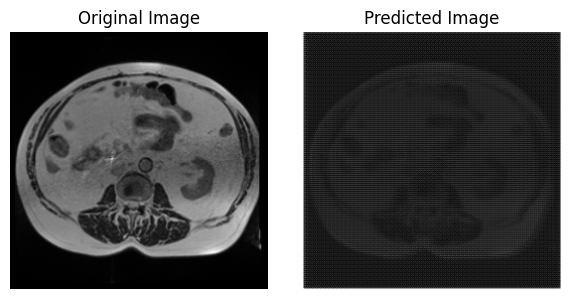

15/15 [==============================] - 11s 704ms/step - loss: 0.0246 - mean_squared_error: 0.0253 - mean_ssim: 0.3452 - val_loss: 0.0583 - val_mean_squared_error: 0.0583 - val_mean_ssim: 0.1781 - lr: 1.0000e-04
Epoch 8/10
15/15 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.0234 - mean_ssim: 0.3684
Epoch 8: val_loss improved from 0.05832 to 0.05291, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 15ms/step


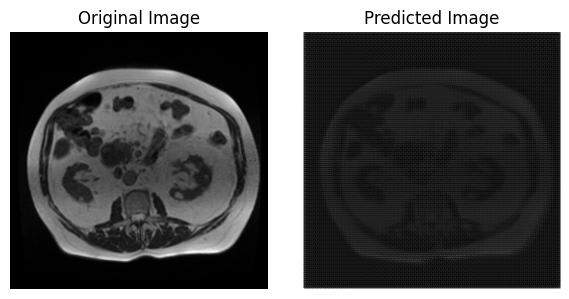

15/15 [==============================] - 11s 722ms/step - loss: 0.0232 - mean_squared_error: 0.0234 - mean_ssim: 0.3684 - val_loss: 0.0529 - val_mean_squared_error: 0.0529 - val_mean_ssim: 0.1878 - lr: 1.0000e-04
Epoch 9/10
15/15 [==============================] - ETA: 0s - loss: 0.0223 - mean_squared_error: 0.0232 - mean_ssim: 0.3777
Epoch 9: val_loss improved from 0.05291 to 0.04941, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 16ms/step


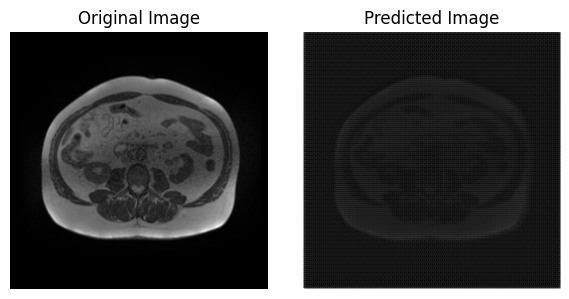

15/15 [==============================] - 11s 738ms/step - loss: 0.0223 - mean_squared_error: 0.0232 - mean_ssim: 0.3777 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_ssim: 0.1943 - lr: 1.0000e-04
Epoch 10/10
15/15 [==============================] - ETA: 0s - loss: 0.0216 - mean_squared_error: 0.0220 - mean_ssim: 0.3946
Epoch 10: val_loss improved from 0.04941 to 0.04658, saving model to best_model_no_aug.h5
1/1 [==============================] - 0s 31ms/step


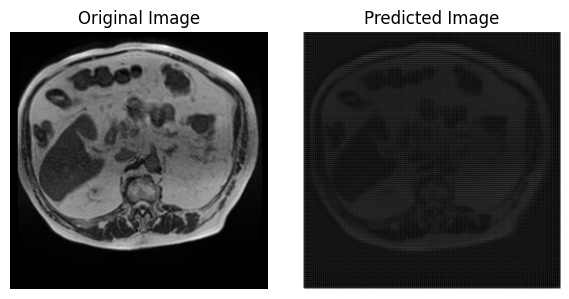

15/15 [==============================] - 11s 721ms/step - loss: 0.0216 - mean_squared_error: 0.0220 - mean_ssim: 0.3946 - val_loss: 0.0466 - val_mean_squared_error: 0.0465 - val_mean_ssim: 0.2017 - lr: 1.0000e-04


In [74]:
# Training Stage

# initialize both model instances
model_with_aug = unet()  
model_without_aug = unet() 

# defining checkpoints and patience (set between 10-20)
checkpoint_aug = ModelCheckpoint('best_model_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_no_aug = ModelCheckpoint('best_model_no_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

# defining ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=1e-6, verbose=1)

# calling viz func
vis_callback_with_aug = VisualizeSegmentation(model_with_aug, validation_data=(images_val,), num_samples=1)
vis_callback_without_aug = VisualizeSegmentation(model_without_aug, validation_data=(images_val,), num_samples=1)

# training WITH NO data augmentation
history_without_aug = model_without_aug.fit(
    x=images_train, # updating weight in training
    y=images_train,  # autoencoder-like training
    validation_data=(images_val, images_val), # validation data includes images only
    batch_size=batch_size, 
    epochs=10, 
    callbacks=[checkpoint_no_aug, early_stopping, reduce_lr, vis_callback_without_aug]
)

## training WITH data augmentation
#history_with_aug = model_with_aug.fit(
#    augmented_generator(images_train, batch_size, seed, apply_augmentation=True),
#    steps_per_epoch=len(images_train) // batch_size,
#    validation_data=(images_val, images_val), # validation data includes images only
#    epochs=10, 
#    callbacks=[checkpoint_aug, early_stopping, reduce_lr, vis_callback_with_aug]
#)

Confusion Matrix

- calculates the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) based on predicted and true labels for each class
- need actual predictions of the model on the training and validation datasets, not auto stored so we need to generate them and store them
- since we have a multi-class problem, the CM must be multiplied by the number of classes we have i.e. 3x3

In [ ]:
# get predictions for visualization
def get_predictions(model, images):
    preds = model.predict(images)
    return preds

def visualize_reconstructions(true_images, pred_images_no_aug, pred_images_aug):
    num_samples = min(len(true_images), 5)  # Number of samples to visualize

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # True image
        axes[i, 0].imshow(true_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Predicted image without augmentation
        axes[i, 1].imshow(pred_images_no_aug[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed Image (No Augmentation)')
        axes[i, 1].axis('off')

        # Predicted image with augmentation
        axes[i, 2].imshow(pred_images_aug[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Reconstructed Image (With Augmentation)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Get reconstructed images for validation set
true_images = images_val
pred_images_no_aug = get_predictions(model_without_aug, images_val)
pred_images_aug = get_predictions(model_with_aug, images_val)

visualize_reconstructions(true_images, pred_images_no_aug, pred_images_aug)

Check the Keys from Training/Validation History and Make Sure they:
- match
- are accounted for

In [ ]:
# grab and sort non-augmented model keys from model history
train_keys_no_aug = sorted(history_without_aug.history.keys())  
val_keys_no_aug = [key for key in train_keys_no_aug if key.startswith('val_')]  
train_keys_no_aug = [key for key in train_keys_no_aug if not key.startswith('val_')]

# grab and sort augmented model keys from model history
train_keys_aug = sorted(history_with_aug.history.keys())  
val_keys_aug = [key for key in train_keys_aug if key.startswith('val_')]  
train_keys_aug = [key for key in train_keys_aug if not key.startswith('val_')]  

# pair up matching keys
def pair_and_print_keys(train_keys, val_keys):
    key_pairs = []

    for key in train_keys:
        val_key = f'val_{key}'
        if val_key in val_keys:  # val key exists?
            key_pairs.append((key, val_key)) 
        else:
            key_pairs.append((key, None))  # add just train key if no val key

    # add any unpaired val keys
    for key in val_keys:
        train_key = key[4:]  # Remove 'val_' prefix to get the corresponding training key
        if train_key not in train_keys:  # does training key exist?
            key_pairs.append((None, key)) # does training key exist?

    # adding some structure to debug the list
    print(f'{"Training Key":<40}{"Validation Key"}') 
    print("="*70)  # separator for legiblity
    for train_key, val_key in key_pairs:
        train_key_str = train_key if train_key is not None else ''  # bug fix: convert None to empty string for training key
        val_key_str = val_key if val_key is not None else ''  # same here
        print(f'{train_key_str:<40}{val_key_str}')  # columns for legibility

# non-augmented model key list
print("Non-Augmented Model Metrics:")
pair_and_print_keys(train_keys_no_aug, val_keys_no_aug)

# augmented model key list
print("\nAugmented Model Metrics:")
pair_and_print_keys(train_keys_aug, val_keys_aug)

PLOT 1: Compare Performance (mean class accuracy & mean class loss) For Non-Agumented & Augmented Models

- compares mean loss and mean accuracy AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

In [ ]:
# Extract metrics from history for plotting
train_loss_with_aug = history_with_aug.history['mean_combined_loss']
val_loss_with_aug = history_with_aug.history['val_mean_combined_loss']
train_accuracy_with_aug = history_with_aug.history['mean_accuracy_metric']
val_accuracy_with_aug = history_with_aug.history['val_mean_accuracy_metric']

train_loss_without_aug = history_without_aug.history['mean_combined_loss']
val_loss_without_aug = history_without_aug.history['val_mean_combined_loss']
train_accuracy_without_aug = history_without_aug.history['mean_accuracy_metric']
val_accuracy_without_aug = history_without_aug.history['val_mean_accuracy_metric']

# Define the number of epochs
epochs = range(1, len(train_loss_with_aug) + 1)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Loss
axs[0, 0].plot(epochs, train_loss_without_aug, color="orange", linestyle="-", label='Training Loss (mean combined loss)')
axs[0, 0].plot(epochs, val_loss_without_aug, color="blue", linestyle="-", label='Validation Loss (mean combined loss)')
axs[0, 0].set_title('Unaugmented Model - Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, max(max(train_loss_without_aug), max(val_loss_without_aug)) + 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - Accuracy
axs[1, 0].plot(epochs, train_accuracy_without_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
axs[1, 0].plot(epochs, val_accuracy_without_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
axs[1, 0].set_title('Unaugmented Model - Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Loss
axs[0, 1].plot(epochs, train_loss_with_aug, color="orange", linestyle="-", label='Training Loss (mean combined loss)')
axs[0, 1].plot(epochs, val_loss_with_aug, color="blue", linestyle="-", label='Validation Loss (mean combined loss)')
axs[0, 1].set_title('Augmented Model - Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, max(max(train_loss_with_aug), max(val_loss_with_aug)) + 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - Accuracy
axs[1, 1].plot(epochs, train_accuracy_with_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
axs[1, 1].plot(epochs, val_accuracy_with_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
axs[1, 1].set_title('Augmented Model - Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 2: Compare Performance (individual class combined loss & accuracy) for Non-Agumented & Augmented Models

- compares individual losses and individual accuracies AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation 
- primarily for debugging, recommended

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

In [ ]:
# Extract metrics from history for plotting
train_combined_loss_without_aug_class_0 = history_without_aug.history['combined_loss_class_0']
val_combined_loss_without_aug_class_0 = history_without_aug.history['val_combined_loss_class_0']
train_combined_loss_without_aug_class_1 = history_without_aug.history['combined_loss_class_1']
val_combined_loss_without_aug_class_1 = history_without_aug.history['val_combined_loss_class_1']
train_combined_loss_without_aug_class_2 = history_without_aug.history['combined_loss_class_2']
val_combined_loss_without_aug_class_2 = history_without_aug.history['val_combined_loss_class_2']

train_accuracy_without_aug_class_0 = history_without_aug.history['accuracy_class_0']
val_accuracy_without_aug_class_0 = history_without_aug.history['val_accuracy_class_0']
train_accuracy_without_aug_class_1 = history_without_aug.history['accuracy_class_1']
val_accuracy_without_aug_class_1 = history_without_aug.history['val_accuracy_class_1']
train_accuracy_without_aug_class_2 = history_without_aug.history['accuracy_class_2']
val_accuracy_without_aug_class_2 = history_without_aug.history['val_accuracy_class_2']

train_combined_loss_with_aug_class_0 = history_with_aug.history['combined_loss_class_0']
val_combined_loss_with_aug_class_0 = history_with_aug.history['val_combined_loss_class_0']
train_combined_loss_with_aug_class_1 = history_with_aug.history['combined_loss_class_1']
val_combined_loss_with_aug_class_1 = history_with_aug.history['val_combined_loss_class_1']
train_combined_loss_with_aug_class_2 = history_with_aug.history['combined_loss_class_2']
val_combined_loss_with_aug_class_2 = history_with_aug.history['val_combined_loss_class_2']

train_accuracy_with_aug_class_0 = history_with_aug.history['accuracy_class_0']
val_accuracy_with_aug_class_0 = history_with_aug.history['val_accuracy_class_0']
train_accuracy_with_aug_class_1 = history_with_aug.history['accuracy_class_1']
val_accuracy_with_aug_class_1 = history_with_aug.history['val_accuracy_class_1']
train_accuracy_with_aug_class_2 = history_with_aug.history['accuracy_class_2']
val_accuracy_with_aug_class_2 = history_with_aug.history['val_accuracy_class_2']

# Define the number of epochs
epochs = range(1, len(train_combined_loss_without_aug_class_0) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Combined Loss
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_0, color="blue", linestyle="-", label='Training Combined Loss (Class 0)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_0, color="orange", linestyle="-", label='Validation Combined Loss (Class 0)')
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_1, color="blue", linestyle="--", label='Training Combined Loss (Class 1)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_1, color="orange", linestyle="--", label='Validation Combined Loss (Class 1)')
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_2, color="blue", linestyle=":", label='Training Combined Loss (Class 2)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_2, color="orange", linestyle=":", label='Validation Combined Loss (Class 2)')
axs[0, 0].set_title('Unaugmented Model - Combined Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Combined Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - Accuracy
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_0, color="blue", linestyle="-", label='Training Accuracy (Class 0)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_0, color="orange", linestyle="-", label='Validation Accuracy (Class 0)')
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_1, color="blue", linestyle="--", label='Training Accuracy (Class 1)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_1, color="orange", linestyle="--", label='Validation Accuracy (Class 1)')
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_2, color="blue", linestyle=":", label='Training Accuracy (Class 2)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_2, color="orange", linestyle=":", label='Validation Accuracy (Class 2)')
axs[1, 0].set_title('Unaugmented Model - Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Combined Loss
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_0, color="blue", linestyle="-", label='Training Combined Loss (Class 0)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_0, color="orange", linestyle="-", label='Validation Combined Loss (Class 0)')
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_1, color="blue", linestyle="--", label='Training Combined Loss (Class 1)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_1, color="orange", linestyle="--", label='Validation Combined Loss (Class 1)')
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_2, color="blue", linestyle=":", label='Training Combined Loss (Class 2)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_2, color="orange", linestyle=":", label='Validation Combined Loss (Class 2)')
axs[0, 1].set_title('Augmented Model - Combined Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Combined Loss')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - Accuracy
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_0, color="blue", linestyle="-", label='Training Accuracy (Class 0)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_0, color="orange", linestyle="-", label='Validation Accuracy (Class 0)')
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_1, color="blue", linestyle="--", label='Training Accuracy (Class 1)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_1, color="orange", linestyle="--", label='Validation Accuracy (Class 1)')
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_2, color="blue", linestyle=":", label='Training Accuracy (Class 2)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_2, color="orange", linestyle=":", label='Validation Accuracy (Class 2)')
axs[1, 1].set_title('Augmented Model - Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 3: Compare Performance (mean class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares mean Dice loss and mean Jaccard Loss AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

In [ ]:
# Extract metrics from history for plotting
train_dice_with_aug = history_with_aug.history['mean_dice_coef']
val_dice_with_aug = history_with_aug.history['val_mean_dice_coef']
train_iou_with_aug = history_with_aug.history['mean_iou_coef']
val_iou_with_aug = history_with_aug.history['val_mean_iou_coef']

train_dice_without_aug = history_without_aug.history['mean_dice_coef']
val_dice_without_aug = history_without_aug.history['val_mean_dice_coef']
train_iou_without_aug = history_without_aug.history['mean_iou_coef']
val_iou_without_aug = history_without_aug.history['val_mean_iou_coef']

# Define the number of epochs
epochs = range(1, len(train_dice_with_aug) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Dice Coefficient
axs[0, 0].plot(epochs, train_dice_without_aug, color="orange", linestyle="-", label='Training Dice Coefficient (mean)')
axs[0, 0].plot(epochs, val_dice_without_aug, color="blue", linestyle="-", label='Validation Dice Coefficient (mean)')
axs[0, 0].set_title('Unaugmented Model - Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coefficient')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - IoU Coefficient
axs[1, 0].plot(epochs, train_iou_without_aug, color="orange", linestyle="--", label='Training IoU Coefficient (mean)')
axs[1, 0].plot(epochs, val_iou_without_aug, color="blue", linestyle="--", label='Validation IoU Coefficient (mean)')
axs[1, 0].set_title('Unaugmented Model - IoU Coefficient')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('IoU Coefficient')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Dice Coefficient
axs[0, 1].plot(epochs, train_dice_with_aug, color="orange", linestyle="-", label='Training Dice Coefficient (mean)')
axs[0, 1].plot(epochs, val_dice_with_aug, color="blue", linestyle="-", label='Validation Dice Coefficient (mean)')
axs[0, 1].set_title('Augmented Model - Dice Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Dice Coefficient')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - IoU Coefficient
axs[1, 1].plot(epochs, train_iou_with_aug, color="orange", linestyle="--", label='Training IoU Coefficient (mean)')
axs[1, 1].plot(epochs, val_iou_with_aug, color="blue", linestyle="--", label='Validation IoU Coefficient (mean)')
axs[1, 1].set_title('Augmented Model - IoU Coefficient')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU Coefficient')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 4: Compare Performance (individual class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares individual Dice losses and individual Jaccard Losses AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation
- primarily for debugging, recommended
r
(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

In [ ]:
# Extract metrics from history for plotting
train_dice_without_aug_class_0 = history_without_aug.history['dice_coef_class_0']
val_dice_without_aug_class_0 = history_without_aug.history['val_dice_coef_class_0']
train_dice_without_aug_class_1 = history_without_aug.history['dice_coef_class_1']
val_dice_without_aug_class_1 = history_without_aug.history['val_dice_coef_class_1']
train_dice_without_aug_class_2 = history_without_aug.history['dice_coef_class_2']
val_dice_without_aug_class_2 = history_without_aug.history['val_dice_coef_class_2']

train_iou_without_aug_class_0 = history_without_aug.history['iou_coef_class_0']
val_iou_without_aug_class_0 = history_without_aug.history['val_iou_coef_class_0']
train_iou_without_aug_class_1 = history_without_aug.history['iou_coef_class_1']
val_iou_without_aug_class_1 = history_without_aug.history['val_iou_coef_class_1']
train_iou_without_aug_class_2 = history_without_aug.history['iou_coef_class_2']
val_iou_without_aug_class_2 = history_without_aug.history['val_iou_coef_class_2']

train_dice_with_aug_class_0 = history_with_aug.history['dice_coef_class_0']
val_dice_with_aug_class_0 = history_with_aug.history['val_dice_coef_class_0']
train_dice_with_aug_class_1 = history_with_aug.history['dice_coef_class_1']
val_dice_with_aug_class_1 = history_with_aug.history['val_dice_coef_class_1']
train_dice_with_aug_class_2 = history_with_aug.history['dice_coef_class_2']
val_dice_with_aug_class_2 = history_with_aug.history['val_dice_coef_class_2']

train_iou_with_aug_class_0 = history_with_aug.history['iou_coef_class_0']
val_iou_with_aug_class_0 = history_with_aug.history['val_iou_coef_class_0']
train_iou_with_aug_class_1 = history_with_aug.history['iou_coef_class_1']
val_iou_with_aug_class_1 = history_with_aug.history['val_iou_coef_class_1']
train_iou_with_aug_class_2 = history_with_aug.history['iou_coef_class_2']
val_iou_with_aug_class_2 = history_with_aug.history['val_iou_coef_class_2']

# Define the number of epochs
epochs = range(1, len(train_dice_without_aug_class_0) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Dice Coefficient
axs[0, 0].plot(epochs, train_dice_without_aug_class_0, color="blue", linestyle="-", label='Training Dice Coefficient (Class 0)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_0, color="orange", linestyle="-", label='Validation Dice Coefficient (Class 0)')
axs[0, 0].plot(epochs, train_dice_without_aug_class_1, color="blue", linestyle="--", label='Training Dice Coefficient (Class 1)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_1, color="orange", linestyle="--", label='Validation Dice Coefficient (Class 1)')
axs[0, 0].plot(epochs, train_dice_without_aug_class_2, color="blue", linestyle=":", label='Training Dice Coefficient (Class 2)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_2, color="orange", linestyle=":", label='Validation Dice Coefficient (Class 2)')
axs[0, 0].set_title('Unaugmented Model - Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coefficient')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - IoU Coefficient
axs[1, 0].plot(epochs, train_iou_without_aug_class_0, color="blue", linestyle="-", label='Training IoU Coefficient (Class 0)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_0, color="orange", linestyle="-", label='Validation IoU Coefficient (Class 0)')
axs[1, 0].plot(epochs, train_iou_without_aug_class_1, color="blue", linestyle="--", label='Training IoU Coefficient (Class 1)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_1, color="orange", linestyle="--", label='Validation IoU Coefficient (Class 1)')
axs[1, 0].plot(epochs, train_iou_without_aug_class_2, color="blue", linestyle=":", label='Training IoU Coefficient (Class 2)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_2, color="orange", linestyle=":", label='Validation IoU Coefficient (Class 2)')
axs[1, 0].set_title('Unaugmented Model - IoU Coefficient')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('IoU Coefficient')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Dice Coefficient
axs[0, 1].plot(epochs, train_dice_with_aug_class_0, color="blue", linestyle="-", label='Training Dice Coefficient (Class 0)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_0, color="orange", linestyle="-", label='Validation Dice Coefficient (Class 0)')
axs[0, 1].plot(epochs, train_dice_with_aug_class_1, color="blue", linestyle="--", label='Training Dice Coefficient (Class 1)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_1, color="orange", linestyle="--", label='Validation Dice Coefficient (Class 1)')
axs[0, 1].plot(epochs, train_dice_with_aug_class_2, color="blue", linestyle=":", label='Training Dice Coefficient (Class 2)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_2, color="orange", linestyle=":", label='Validation Dice Coefficient (Class 2)')
axs[0, 1].set_title('Augmented Model - Dice Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Dice Coefficient')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - IoU Coefficient
axs[1, 1].plot(epochs, train_iou_with_aug_class_0, color="blue", linestyle="-", label='Training IoU Coefficient (Class 0)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_0, color="orange", linestyle="-", label='Validation IoU Coefficient (Class 0)')
axs[1, 1].plot(epochs, train_iou_with_aug_class_1, color="blue", linestyle="--", label='Training IoU Coefficient (Class 1)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_1, color="orange", linestyle="--", label='Validation IoU Coefficient (Class 1)')
axs[1, 1].plot(epochs, train_iou_with_aug_class_2, color="blue", linestyle=":", label='Training IoU Coefficient (Class 2)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_2, color="orange", linestyle=":", label='Validation IoU Coefficient (Class 2)')
axs[1, 1].set_title('Augmented Model - IoU Coefficient')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU Coefficient')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
- Keep Cell Active During Hypertuning to Break Off Pipeline Before Seeing Test Data
- Deactivate when Tuning Complete

Model Testing
- test model with the test set to see how well it performs on unseen data
- we want our coefficent high and our loss low
- the data augmented model should perform better on testing

Underfitting: both training and validation loss are high -> not learning effectively
Overfitting: training loss continues to decrease while validation loss begins to increase -> not generalizing well to validation data
Good fit: both losses decrease to a point of stability with a minimal gap between the two final loss values

# Testing Stage

# retrieve best model from training
# dont need to add standard metrics Recall, Precision, Accuracy just custom ones
best_model = load_model('best_model.h5', custom_objects={
    'combined_loss': combined_loss,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'multi_class_specificity': multi_class_specificity(3)
})

test_results = best_model.evaluate(images_test, masks_test)

print(f"Test results - Loss: {test_results[0]} - Dice Coefficient: {test_results[1]} - IoU Coefficient: {test_results[2]}")

Visualize Final Segmentation Results (Predicted Masks)

- visualize jsut a subset of the segmentation results below
- save all segmentation result plots to a folder

plot_save_path = '/Users/elizabethnemeti/Desktop/UNET_segmented_masks'  # local runs
# plot_save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_segmented_masks'  # cluster runs

if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# viz for x samples
num_random_samples = 3
idxs = np.random.choice(len(images_test), num_random_samples, replace=False)

selected_preds = best_model.predict(images_test[idxs]) # make prediction

# plots for predications compared to true masks/images
for i, idx in enumerate(idxs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(selected_preds[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# save all the rest of the plots (and amek them) in a folder
for idx in range(len(images_test)):
    pred = best_model.predict(images_test[idx:idx+1])[0].squeeze() # mask prediction

    # make the figures (skip the display)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')

    fig.savefig(os.path.join(plot_save_path, f'visualization_{idx}.png'))
    plt.close(fig) 

print(f"Saved {len(images_test)} visualization plots to: {plot_save_path}")

Performance Plots for Loss & Metrics

- one plot per average score for each metric
- 28 plots (7x4) where
    - 7 metrics =  Dice Coef, IoU Coef, Accuracy, Recall, Precision, Specificity, Loss
    - 4 variables = classes average, tumor class 1, tumor class 2, tumor class 3

Reminder: labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively

# Performance Plots for Loss & Metrics

history_dict = history.history
print(history.history.keys()) # make sure keys match!
print(history_dict)

epochs = range(1, len(history_dict['loss']) + 1) # sets x-axis to epochs correctly

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Dice Coefficient
axs[0, 0].plot(epochs, history_dict['dice_coef'], label='Train Dice Coef')
axs[0, 0].plot(epochs, history_dict['val_dice_coef'], label='Val Dice Coef')
axs[0, 0].set_title('Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coef')
axs[0, 0].legend()

# IoU
axs[0, 1].plot(epochs, history_dict['iou_coef'], label='Train IoU')
axs[0, 1].plot(epochs, history_dict['val_iou_coef'], label='Val IoU')
axs[0, 1].set_title('IoU Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('IoU')
axs[0, 1].legend()

# Accuracy
axs[0, 2].plot(epochs, history_dict['accuracy'], label='Train Accuracy')
axs[0, 2].plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
axs[0, 2].set_title('Accuracy')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].legend()

# Recall/Sensitivity
axs[1, 0].plot(epochs, history_dict['my_recall'], label='Train Recall')  
axs[1, 0].plot(epochs, history_dict['val_my_recall'], label='Val Recall')  
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Precision
axs[1, 1].plot(epochs, history_dict['my_precision'], label='Train Precision')  
axs[1, 1].plot(epochs, history_dict['val_my_precision'], label='Val Precision') 
axs[1, 1].set_title('Precision')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Specificity
axs[1, 2].plot(epochs, history_dict['multi_class_specificity'], label='Train Specificity')  
axs[1, 2].plot(epochs, history_dict['val_multi_class_specificity'], label='Val Specificity')  
axs[1, 2].set_title('Specificity')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Specificity')
axs[1, 2].legend()

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# keeping Loss separate
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
plt.title('Model Combined Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.legend()
plt.show()